# 1 气象数据处理
## CSV文件表头
csv文件结构如下
```
## Site Characteristics
Country     = 'Netherlands'
Station     = 'Wageningen, Haarweg'
Description = 'Observed data from Station Haarweg in Wageningen'
Source      = 'Meteorology and Air Quality Group, Wageningen University'
Contact     = 'Peter Uithol'
Longitude = 5.67; Latitude = 51.97; Elevation = 7; AngstromA = 0.18; AngstromB = 0.55; HasSunshine = False
## Daily weather observations (missing values are NaN)
DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
20040101,NaN,-0.7,1.1,0.55,3.6,0.5,NaN
20040102,3888,-7.5,0.9,0.44,3.1,0,NaN
20040103,2074,-6.8,-0.5,0.45,1.8,0,NaN
20040104,1814,-3.6,5.9,0.66,3.2,2.5,NaN
20040105,1469,3,5.7,0.78,2.3,1.3,NaN
[...]

with
IRRAD in kJ/m2/day or hours
TMIN and TMAX in Celsius (°C)
VAP in kPa
WIND in m/sec
RAIN in mm
SNOWDEPTH in cm
```


In [1]:
## 两日相隔天数
from datetime import datetime
def calDays(start, end, format="%Y-%m-%d"):
    strptime, strftime = datetime.strptime, datetime.strftime
    days = (strptime(end, format) - strptime(start, format)).days
    return days

In [2]:
def csv_header(country="China", station="Yangling", longitude=108.12, latitude=34.33, elevation=521):
    res_s = f"## Site Characteristics\nCountry     = {country}\nStation     = {station}\nDescription = 'Observed data from Station {station} in {country}'\
    \nSource      = 'Meteorology and Air Quality Group, Wageningen University'\nContact     = 'Peter Uithol'\
    \nLongitude = {longitude:.2f}; Latitude = {latitude:.2f}; Elevation = {elevation:.0f}; AngstromA = 0.18; AngstromB = 0.55; HasSunshine = False\
    \n## Daily weather observations (missing values are NaN)"
    return res_s

In [3]:
print(csv_header())

## Site Characteristics
Country     = China
Station     = Yangling
Description = 'Observed data from Station Yangling in China'    
Source      = 'Meteorology and Air Quality Group, Wageningen University'
Contact     = 'Peter Uithol'    
Longitude = 108.12; Latitude = 34.33; Elevation = 521; AngstromA = 0.18; AngstromB = 0.55; HasSunshine = False    
## Daily weather observations (missing values are NaN)


# 2 读取模型参数

In [4]:
%matplotlib inline
import sys, os
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd

data_dir = os.path.join(os.getcwd(), "data")
import pcse
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.15 (default, Nov  4 2022, 15:16:59) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.5.4


## 2.1 作物参数

In [5]:
from pcse.fileinput import CABOFileReader
from pcse.exceptions import PCSEError, PartitioningError

In [6]:
cropfile = os.path.join(data_dir, 'crop', 'MAG201.CAB')
cropd = CABOFileReader(cropfile)
print(cropd)

** $Id: mag201.cab 1.3 1997/09/25 14:06:58 LEM release $
** File MAG201.CAB
** CROP DATA FILE for use with WOFOST Version 5.4, June 1992
**
** GRAIN MAIZE 201
** Regions : Germany, R13, R15, R16, R17 and Luxembourg
** sowing date 1 May
** mean date of flowering 26 July, mature 20 October
** Derived from SUCROS87 data set for maize.
** Calibrated for use in WOFOST model at the Centre for Agrobiological
** Research (CABO-DLO) for the simulation of crop growth and yield on the
** basis of daily weather data.
** Purpose of application: Crop growth monitoring with agrometeorological
** model in the EC.
** Developed in the framework of JRC Agriculture Project Action 3.
**
------------------------------------
TBASEM: 4.0 <class 'float'>
TEFFMX: 30.0 <class 'float'>
TSUMEM: 110.0 <class 'float'>
IDSL: 0 <class 'int'>
DLO: -99.0 <class 'float'>
DLC: -99.0 <class 'float'>
TSUM1: 695.0 <class 'float'>
TSUM2: 800.0 <class 'float'>
DVSI: 0.0 <class 'float'>
DVSEND: 2.0 <class 'float'>
TDWI: 50.0 <c

## 2.2 土壤参数

In [7]:
soilfile = os.path.join(data_dir, 'soil', 'ec3.soil')
soild = CABOFileReader(soilfile)

## 2.3 站点数据

In [8]:
from pcse.util import WOFOST72SiteDataProvider
sited = WOFOST72SiteDataProvider(WAV=18)

## 2.4 整合模型参数

In [9]:
from pcse.base import ParameterProvider
# parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)
class CropParam:
    def __init__(self, crop_file, soildata, sitedata):
        self.cropd_file = crop_file
        self.cropd = None
        self.cropd1()
        self.soild = soildata
        self.sited = sitedata
        self.params = ParameterProvider(cropdata=self.cropd, soildata=self.soild, sitedata=self.sited)
    def cropd1(self):
        self.cropd = CABOFileReader(self.cropd_file)
    def initial(self):
        self.cropd1()
        return ParameterProvider(cropdata=self.cropd, soildata=self.soild, sitedata=self.sited)

In [10]:
# cropfile = os.path.join(data_dir, 'crop', 'MAG201.CAB')
# crop_param = CropParam(cropfile, soild, sited)
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

## 2.5 管理文件

In [11]:
from pcse.fileinput import YAMLAgroManagementReader
agromanagement21 = YAMLAgroManagementReader(os.path.join(data_dir, 'agro', 'maize_2021.agro'))
agromanagement22 = YAMLAgroManagementReader(os.path.join(data_dir, 'agro', 'maize_2022.agro'))

## 2.6气象数据

In [12]:
from pcse.fileinput import ExcelWeatherDataProvider
weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)
# print(wdp)

## 测试参数是否可用于敏感性分析

TMPFTB=[0, 4, 16, 18, 20, 28, 36, 42]
TMNFTB = 8℃
RFSETB 只涉及后两个参数[0, 1.5, 1.75, 2]

In [13]:
from pcse.models import Wofost72_PP, Wofost72_WLP_FD
wofostpp = Wofost72_PP(parameters, wdp, agromanagement21)
wofostwlp = Wofost72_WLP_FD(parameters, wdp, agromanagement21)
wofostpp.run_till_terminate()
wofostwlp.run_till_terminate()

In [14]:
r = wofostwlp.get_output()

In [15]:
wofostwlp.get_summary_output()

[{'DVS': 2.0,
  'LAIMAX': 1.374125857971024,
  'TAGP': 6481.005715263842,
  'TWSO': 3696.896648798934,
  'TWLV': 862.3064007340049,
  'TWST': 1921.8026657309024,
  'TWRT': 481.2448555816113,
  'CTRAT': 9.615071426324379,
  'RD': 84.80000000000005,
  'DOS': datetime.date(2021, 6, 11),
  'DOE': datetime.date(2021, 6, 16),
  'DOA': datetime.date(2021, 7, 20),
  'DOM': datetime.date(2021, 8, 29),
  'DOH': None,
  'DOV': None,
  'CEVST': 5.759676374580274}]

In [16]:
i = calDays("2021-06-11", "2021-09-20")
i

101

In [17]:
param_name = ["TDWI", "LAIEM", "RGRLAI", "SLATB", "SPAN", "TBASE", "KDIFTB", "EFFTB", "AMAXTB", "TMPFTB", "TMNFTB", "CVL", "CVO", "CVR", "CVS", "Q10", "RML",
              "RMO", "RMR", "RMS", "RFSETB", "FRTB", "FLTB", "FOTB", "RDRRTB", "RDRSTB", "CFET", "DEPNR", "RDI", "RRI", "RDMCR"]

In [18]:
for each in param_name:
    try:
        print("**************\n")
        print(each)
        print(parameters[each])

    except KeyError:
        print(each)

**************

TDWI
50.0
**************

LAIEM
0.04836
**************

RGRLAI
0.0294
**************

SLATB
[0.0, 0.0026, 0.78, 0.0012, 2.0, 0.0012]
**************

SPAN
33.0
**************

TBASE
10.0
**************

KDIFTB
[0.0, 0.6, 2.0, 0.6]
**************

EFFTB
[0.0, 0.45, 40.0, 0.45]
**************

AMAXTB
[0.0, 70.0, 1.25, 70.0, 1.5, 63.0, 1.75, 49.0, 2.0, 21.0]
**************

TMPFTB
[0.0, 0.01, 9.0, 0.05, 16.0, 0.8, 18.0, 0.94, 20.0, 1.0, 30.0, 1.0, 36.0, 0.95, 42.0, 0.56]
**************

TMNFTB
[5.0, 0.0, 8.0, 1.0]
**************

CVL
0.68
**************

CVO
0.671
**************

CVR
0.69
**************

CVS
0.658
**************

Q10
2.0
**************

RML
0.03
**************

RMO
0.01
**************

RMR
0.015
**************

RMS
0.015
**************

RFSETB
[0.0, 1.0, 1.5, 1.0, 1.75, 0.75, 2.0, 0.25]
**************

FRTB
[0.0, 0.4, 0.1, 0.37, 0.2, 0.34, 0.3, 0.31, 0.4, 0.27, 0.5, 0.23, 0.6, 0.19, 0.7, 0.15, 0.8, 0.1, 0.9, 0.06, 1.0, 0.0, 2.0, 0.0]
**************

FLTB
[0

# 3 敏感性分析

In [2]:
import pandas as pd
import yaml
import numpy as np
# import pandas as pd
from SALib.sample import sobol as sobolSample
from SALib.analyze import sobol, fast
# import matplotlib.pyplot as plt
from IPython.display import display
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 250)
from progressbar import printProgressBar, PrintProgressBar

## 3.1敏感性分析设置

In [5]:
# Define the target variable
# target_variable = ["TWSO", "TWLV", "TWST", "TAGP", "LAImax"]
with open(os.path.join(data_dir, 'yaml', 'params.yaml'), 'r', encoding='utf-8') as f:
    problem_yaml = f.read()
# For each scalar parameter, determine a sensible interval
# problem_yaml = """
#     num_vars: 5
#     names:
#     - TSUM1
#     - TSUM2
#     - SPAN
#     - Q10
#     - TDWI
#     bounds:
#     - [500, 800]
#     - [1200, 1600]
#     - [28, 37]
#     - [1.8, 2.2]
#     - [0.4, 0.6]
# """
problem = yaml.safe_load(problem_yaml)

In [6]:

calc_second_order = True
nsamples = 2 ** 6
paramsets = sobolSample.sample(problem, nsamples, calc_second_order=calc_second_order)
print("We are going to do %s simulations" % len(paramsets))

We are going to do 6656 simulations


In [7]:
# from SALib.sample.fast_sampler import sample as efast_sample
# nsamples = 75
# paramsets = efast_sample(problem, nsamples, 4, seed=666)

In [8]:
# 修改作物参数用
param_dict = {
    "SLATB": {"SLATB1": [0.00, 1], "SLATB2": [0.50, 3], "SLATB3": [0.78, 5], "SLATB4": [2.00, 7]},
    "KDIFTB": {"KDIFTB1": [0.0, 1], "KDIFTB2": [2.0, 3]},
    "EFFTB": {"EFFTB1": [0.0, 1], "EFFTB2": [40.0, 3]},
    "AMAXTB": {"AMAXTB1": [0.00, 1], "AMAXTB2": [1.25, 3], "AMAXTB3": [1.50, 5], "AMAXTB4": [1.75, 7], "AMAXTB5": [2.00, 9]},
    "TMPFTB": {
        "TMPFTB1": [0.00, 1],
        "TMPFTB2": [4.00, 3],
        "TMPFTB3": [16.00, 5],
        "TMPFTB4": [18.00, 7],
        "TMPFTB5": [20.00, 9],
        "TMPFTB6": [28.00, 11],
        "TMPFTB7": [36.00, 13],
        "TMPFTB8": [42.00, 15]
    },
    "TMNFTB": {"TMNFTB1": [8.00, 3]},
    "RFSETB": {
        "RFSETB1": [1.75, 5],
        "RFSETB2": [2.00, 7],
    },
    "FRTB": {
        "FRTB1": [0.00, 1],
        "FRTB2": [0.70, 15],
        "FRTB3": [0.90, 19]
    },
    "FLTB": {
        "FLTB1": [0.00, 1],
        "FLTB2": [0.33, 3],
        "FLTB3": [0.88, 5],
        "FLTB4": [1.10, 9],
    },
    "FOTB": {"FOTB1": [1.25, 7]},
    "RDRRTB": {
        "RDRRTB1": [1.5001, 5],
        "RDRRTB2": [2.00, 7]
    },
    "RDRSTB": {
        "RDRSTB1": [1.5001, 5],
        "RDRSTB2": [2.00, 7],
    }
}

In [25]:

# parameters.clear_override()
# for name, value in zip(problem["names"], paramsets[0]):
#     try:
#         parameters.set_override(name, value)
#     except PCSEError:
#         tmp_n = name[: -1]
#         tem_d1 = param_dict[tmp_n]
#         tmp_list = tem_d1[name]
#         tmp_value = parameters[tmp_n]
#         try:
#             tmp_value[tmp_list[1] -1], tmp_value[tmp_list[1]] = tmp_list[0], value
#         except IndexError:
#             tmp_value.extend([tmp_list[0], value])
#             print(tmp_value)
#         parameters.set_override(tmp_n, tmp_value)


In [26]:
def deciaml1(num:float, n:int):
    return int(num * 10**n) / 10 ** n

In [27]:
# parameters = crop_param.initial()
# parameters.set_override("FLTB", [0.00, 0.62, 0.33, 0.59, 0.88, 0.16, 0.95, 0.15, 1.10, 0.11, 1.20, 0.00, 2.00, 0.00])
# wofostpp = Wofost72_PP(parameters, wdp, agromanagement21)
# wofostpp.run_till_terminate()

In [28]:
from pcse.models import Wofost72_PP, Wofost72_WLP_FD

### 3.1.1设置提取的值 

In [29]:
def parase_model_ouput(model_outplut: list, var_name: list, pid, idx=0):
    res_ = list()
    for each in var_name:
        try:
            res_.append(model_outplut[idx][each])
        except KeyError as e:
            print("%s\n 不存在key=%s"%(e, each))
            res_.append(None)
        except IndexError:
            res_.append(None)
    
    res_.append(pid)
    return res_

In [30]:
def create_dict(key_das):
    res_dict = dict()
    res_dict["0"] = list()
    for each in key_das:
        dict_key = str(each)
        res_dict[dict_key] = list()
    return res_dict


def get_wofost_output(wofostModel, var_names, template_dict, pid, var_list=None):
    wofostModel.run_till_terminate()
    r = wofostModel.get_summary_output()
    tmp_res = parase_model_ouput(r, var_name=var_names, pid=pid, idx=0)
    template_dict["0"].append(tmp_res)
    if var_list is None:
        pass
    else:
        days, name_ = var_list
        r = wofostModel.get_output()
        for ii in days:
            # print(ii)
            tmp_res = None
            tmp_res = parase_model_ouput(r, var_name=name_, idx=ii, pid=pid)
            template_dict[str(ii)].append(tmp_res)
    
    return template_dict



In [31]:
final_target = ["LAIMAX", "TAGP", "TWSO", "DOE", "DOA", "DOM"]
time_target = ["LAI", "TAGP"]
das = [18, 27, 37, 48, 56, 65, 75, 85, 95]
model_start_date = "2021-06-01"
sowing_date = "2021-06-11"
base_i = calDays(model_start_date, sowing_date)
for idx, value_ in enumerate(das):
    das[idx] = base_i + value_

In [32]:
import time
from progressbar import printProgressBar, PrintProgressBar

In [ ]:
nsets = len(paramsets)
result_pp = create_dict(das)
result_wlp = create_dict(das)
pbar = PrintProgressBar(nsets, prefix='Progress:', suffix='Complete', decimals=1, length=50, fill='█', printEnd="\r")
pbar.printProgressBar(0)
# printProgressBar(0, nsets, prefix = 'Progress:', suffix = 'Complete', length = 50)
for i, paramset in enumerate(paramsets):
    parameters.clear_override()
    ## 修改敏感参数值
    for name, value in zip(problem["names"], paramsets[0]):
        try:
            parameters.set_override(name, value)
        except PCSEError:
            tmp_n = name[: -1]
            tem_d1 = param_dict[tmp_n]
            tmp_list = tem_d1[name]
            tmp_value = parameters[tmp_n]
            try:
                tmp_value[tmp_list[1] -1], tmp_value[tmp_list[1]] = tmp_list[0], value
            except IndexError:
                tmp_value.extend([tmp_list[0], value])
                # print(tmp_value)
            parameters.set_override(tmp_n, tmp_value)
    ## 模型运算
    # 潜在产量数据
    tmp_res = None
    try:
        wofostpp = Wofost72_PP(parameters, wdp, agromanagement21)
        wofostwlp = Wofost72_WLP_FD(parameters, wdp, agromanagement21)
        result_pp = get_wofost_output(wofostpp, final_target, result_pp, pid=i, var_list=(das, time_target))
        result_wlp = get_wofost_output(wofostwlp, final_target, result_wlp, pid=i, var_list=(das, time_target))
        
    except ZeroDivisionError as e:
        print(e)

    pbar.printProgressBar(i+1)


In [72]:
col1 = final_target.copy()
col2 = time_target.copy()
col1.extend(["id"])
col2.extend(["id"])
result_pp["names1"] = col1
result_pp["names2"] = col2
result_wlp["names1"] = col1
result_wlp["names2"] = col2

In [10]:
import pickle
pkl_file = "./data/pickleFile/result_pp_sobol_2021.pkl"
pkl_data = paramsets
with open(pkl_file, 'rb') as pf:
    result_pp = pickle.load(pf)

[[0.5424668463934613,
  2714.9659479432967,
  1535.2548843158977,
  datetime.date(2021, 6, 20),
  datetime.date(2021, 7, 23),
  datetime.date(2021, 9, 3),
  0],
 [0.5566733556226992,
  2778.08015991957,
  1569.1925801398559,
  datetime.date(2021, 6, 20),
  datetime.date(2021, 7, 23),
  datetime.date(2021, 9, 3),
  1],
 [0.5424668463934613,
  2714.9659479432967,
  1535.2548843158977,
  datetime.date(2021, 6, 20),
  datetime.date(2021, 7, 23),
  datetime.date(2021, 9, 3),
  2],
 [0.5139604323486922,
  2585.9920218405546,
  1462.8404438639427,
  datetime.date(2021, 6, 20),
  datetime.date(2021, 7, 23),
  datetime.date(2021, 9, 3),
  3],
 [0.5527486481778591,
  2763.2506217015416,
  1566.0935047517921,
  datetime.date(2021, 6, 20),
  datetime.date(2021, 7, 23),
  datetime.date(2021, 9, 3),
  4],
 [0.5398457786443956,
  2703.2672832128806,
  1525.9095396847279,
  datetime.date(2021, 6, 20),
  datetime.date(2021, 7, 23),
  datetime.date(2021, 9, 3),
  5],
 [0.5426656788247142,
  2715.7608733

In [14]:
df_pp = pd.DataFrame(result_pp["0"], columns=["LAIMAX", "TAGP", "TWSO", "DOE", "DOA", "DOM", "ID"])

In [25]:
Y = df_pp["DOM"]

In [26]:
Y = Y.to_numpy()

In [27]:
Y

array([datetime.date(2021, 9, 3), datetime.date(2021, 9, 3),
       datetime.date(2021, 9, 3), ..., datetime.date(2021, 8, 29),
       datetime.date(2021, 9, 1), datetime.date(2021, 9, 1)], dtype=object)

In [23]:
Si = sobol.analyze(problem, Y, calc_second_order=calc_second_order)

<AxesSubplot:xlabel='Parameter'>

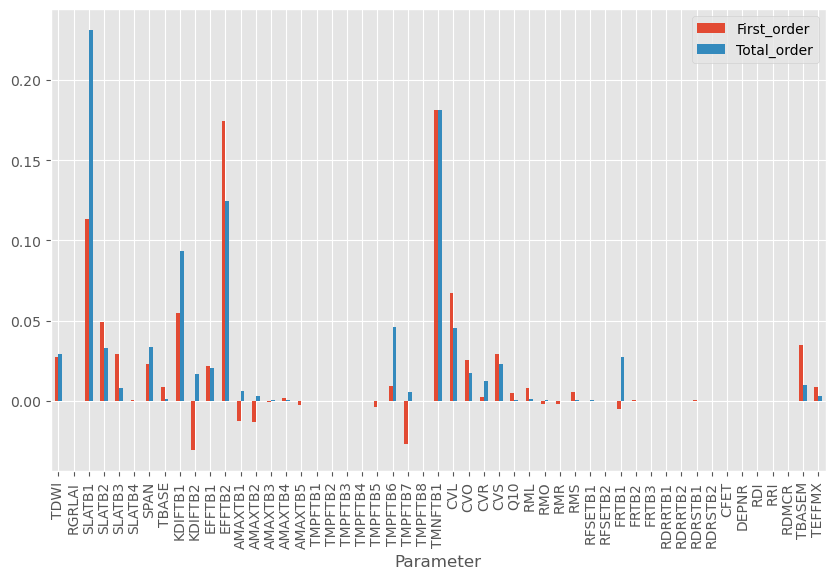

In [24]:
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
fig, axes = plt.subplots(figsize=(10,6))
df_sensitivity.plot(kind="bar", ax=axes)

'01'

{'DVS': 2.0,
 'LAIMAX': 1.374125857971024,
 'TAGP': 6481.005715263842,
 'TWSO': 3696.896648798934,
 'TWLV': 862.3064007340049,
 'TWST': 1921.8026657309024,
 'TWRT': 481.2448555816113,
 'CTRAT': 9.615071426324379,
 'RD': 84.80000000000005,
 'DOS': datetime.date(2021, 6, 11),
 'DOE': datetime.date(2021, 6, 16),
 'DOA': datetime.date(2021, 7, 20),
 'DOM': datetime.date(2021, 8, 29),
 'DOH': None,
 'DOV': None,
 'CEVST': 5.01454052211001}

In [294]:
# row, col = paramsets.shape
# name = problem["names"]
# for i in range(0, 2):
#     print(name[i])
#     flag = 0
#     for j in range(20):
#         value = deciaml1(paramsets[j][i], 3)
#         parameters = crop_param.initial()
#         try:
#             parameters.set_override(name[i], value)
#         except PCSEError:
#             tmp_n = name[i][:-1]

#             tem_d1 = param_dict[tmp_n]
#             tmp_list = tem_d1[name[i]]
#             tmp_value = parameters[tmp_n]
#             try:
#                 tmp_value[tmp_list[1] -1], tmp_value[tmp_list[1]] = tmp_list[0], value
#             except IndexError:
#                 tmp_value.extend([tmp_list[0], value])
#             parameters.set_override(tmp_n, tmp_value)
#         try:
#             wofostpp = Wofost72_PP(parameters, wdp, agromanagement21)
#             wofostpp.run_till_terminate()
#             flag += 1
#         except ZeroDivisionError:
#             pass
#         except PartitioningError:
#             print("Error in partitioning")
#     print(flag)

TDWI
20
LAIEM
20


In [265]:
paramsets[j][i]

[0.0, 0.62, 0.33, 0.545, 0.88, 0.15, 0.95, 0.15, 1.1, 0.1, 1.2, 0.0, 2.0, 0.0]